In [1]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

=== АНАЛИЗ НА ЗЕМНИ РАБОТИ ===

Брой измерени точки: 150
Обхват на терена: 119.8м × 79.0м
Площ на терена: 0.95 дка

=== ВИСОЧИНИ ===
Съществуващ терен: 570.82м - 578.35м
Проектен терен: 573.45м - 573.64м
Средна разлика: -0.57м

=== ЗЕМНИ РАБОТИ ===
Точки за насип: 58 (38.7%)
Точки за изкоп: 92 (61.3%)
Средна височина насип: 1.40м
Максимален насип: 2.67м
Средна дълбочина изкоп: 1.82м
Максимален изкоп: 4.75м

=== ОБЕМИ (приблизително) ===
Общ обем насип: 5786 м³
Общ обем изкоп: 25305 м³
Нетен обем: -19519 м³


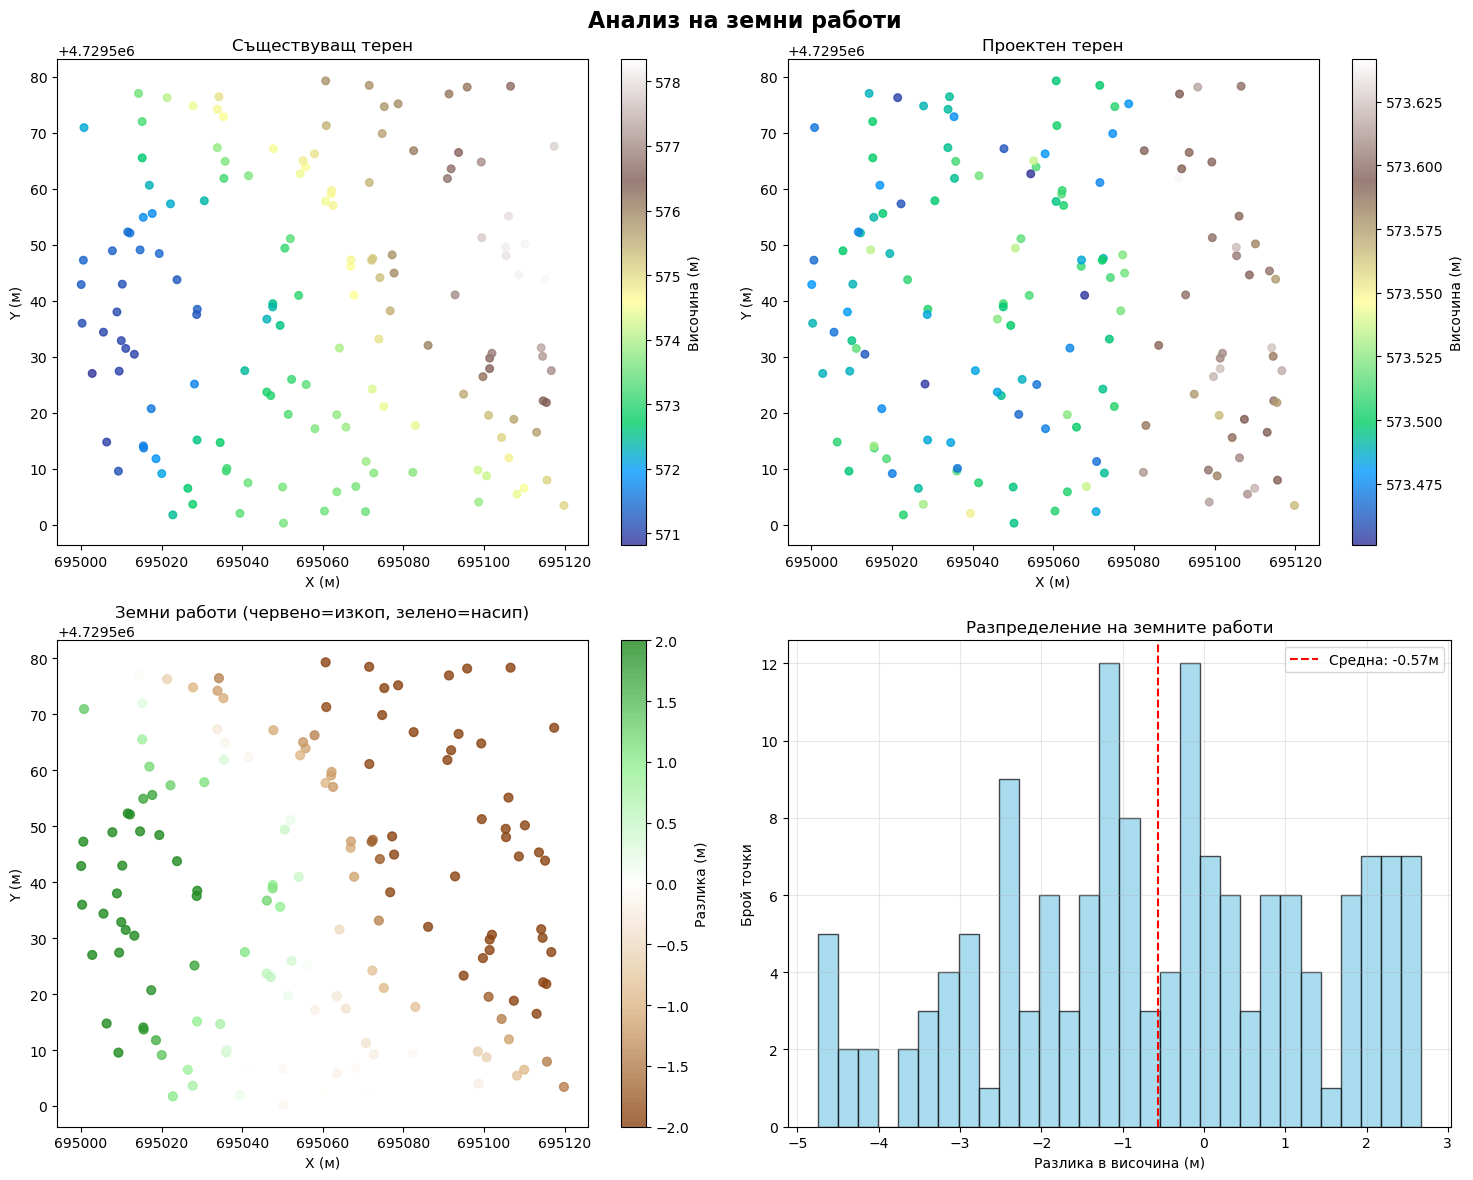


=== ПРОФИЛИ ===


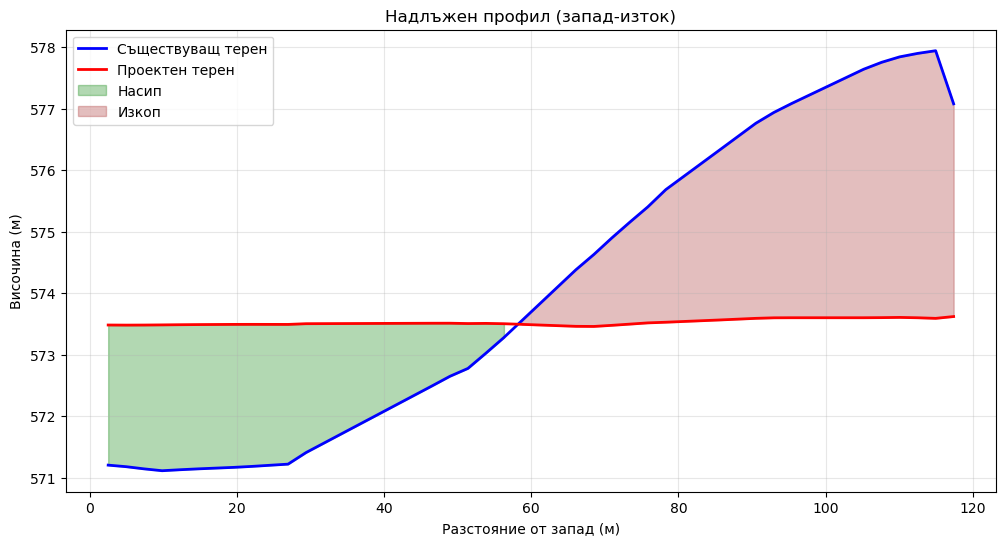


=== ЗАПАЗВАНЕ НА ДАННИ ===
GeoDataFrame съдържа:
               X             Y  Z_existing   Z_project  \
0  695062.075746  4.729559e+06  574.640059  573.514601   
1  695113.635512  4.729545e+06  578.351098  573.600834   
2  695091.855171  4.729564e+06  576.688566  573.592054   
3  695033.887501  4.729574e+06  574.673926  573.492468   
4  695026.525444  4.729506e+06  572.675092  573.491221   

                         geometry    Z_diff Work_type       Area      Volume  
0  POINT (695062.076 4729559.043) -1.125457     Изкоп   4.014404   -4.518041  
1  POINT (695113.636 4729545.305) -4.750264     Изкоп  49.526123 -235.262141  
2   POINT (695091.855 4729563.55) -3.096512     Изкоп  26.428467  -81.836066  
3  POINT (695033.888 4729574.181) -1.181459     Изкоп  16.265625  -19.217162  
4  POINT (695026.525 4729506.469)  0.816129     Насип  42.414062   34.615328  

За запазване на данните можете да използвате:
gdf.to_file('zemni_raboti.shp')  # Shapefile
gdf.to_file('zemni_raboti.geojson',

In [2]:


# Настройка на български шрифт за графиките
plt.rcParams['font.size'] = 10

# Създаване на данните (копирам оригиналния код)
np.random.seed(23)
num_points = 150
x0, y0 = 695000, 4729500

# Разпръскване на точки в района
Xp = x0 + np.random.uniform(0, 120, num_points)
Yp = y0 + np.random.uniform(0, 80, num_points)

# Съществуващ терен със склон и микрорелеф + случайна грешка
Zp_existing = (570 + 0.05*(Xp-x0) + 0.03*(Yp-y0) + 
               1.4 * np.sin((Xp-x0)/22) * np.cos((Yp-y0)/14) + 
               np.random.normal(0, 0.06, num_points))

# Проектен терен - почти равен
Zp_project = 573.5 + np.random.normal(0, 0.02, num_points)
Zp_project[Xp-x0 > 80] += 0.1  # насипка в дясната половина

# Създаване на GeoDataFrame
geometry = [Point(x, y) for x, y in zip(Xp, Yp)]
gdf = gpd.GeoDataFrame({
    'X': Xp,
    'Y': Yp,
    'Z_existing': Zp_existing,
    'Z_project': Zp_project,
    'geometry': geometry
})

# Изчисляване на разликата (положителна = насип, отрицателна = изкоп)
gdf['Z_diff'] = gdf['Z_project'] - gdf['Z_existing']
gdf['Work_type'] = gdf['Z_diff'].apply(lambda x: 'Насип' if x > 0 else 'Изкоп')

# Статистики
print("=== АНАЛИЗ НА ЗЕМНИ РАБОТИ ===\n")
print(f"Брой измерени точки: {len(gdf)}")
print(f"Обхват на терена: {Xp.max()-Xp.min():.1f}м × {Yp.max()-Yp.min():.1f}м")
print(f"Площ на терена: {(Xp.max()-Xp.min()) * (Yp.max()-Yp.min()) / 10000:.2f} дка")

print("\n=== ВИСОЧИНИ ===")
print(f"Съществуващ терен: {gdf['Z_existing'].min():.2f}м - {gdf['Z_existing'].max():.2f}м")
print(f"Проектен терен: {gdf['Z_project'].min():.2f}м - {gdf['Z_project'].max():.2f}м")
print(f"Средна разлика: {gdf['Z_diff'].mean():.2f}м")

print("\n=== ЗЕМНИ РАБОТИ ===")
nasip_points = gdf[gdf['Z_diff'] > 0]
izkop_points = gdf[gdf['Z_diff'] < 0]

print(f"Точки за насип: {len(nasip_points)} ({len(nasip_points)/len(gdf)*100:.1f}%)")
print(f"Точки за изкоп: {len(izkop_points)} ({len(izkop_points)/len(gdf)*100:.1f}%)")

if len(nasip_points) > 0:
    print(f"Средна височина насип: {nasip_points['Z_diff'].mean():.2f}м")
    print(f"Максимален насип: {nasip_points['Z_diff'].max():.2f}м")

if len(izkop_points) > 0:
    print(f"Средна дълбочина изкоп: {abs(izkop_points['Z_diff'].mean()):.2f}м")
    print(f"Максимален изкоп: {abs(izkop_points['Z_diff'].min()):.2f}м")

# Приблизително изчисляване на обеми (с Voronoi диаграми)
from scipy.spatial import Voronoi
points_2d = np.column_stack([Xp, Yp])
vor = Voronoi(points_2d)

# Изчисляване на площите на Voronoi клетките
def voronoi_areas(vor, bounds):
    """Изчислява площите на Voronoi клетките в дадени граници"""
    areas = []
    for i, point in enumerate(vor.points):
        region_idx = vor.point_region[i]
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            areas.append(0)  # Безкрайна или празна област
        else:
            vertices = vor.vertices[region]
            # Проверка дали е в границите
            if (bounds[0] <= point[0] <= bounds[2] and 
                bounds[1] <= point[1] <= bounds[3]):
                # Изчисляване на площта с формулата на Gauss
                area = 0.5 * abs(sum(vertices[i][0] * vertices[(i+1)%len(vertices)][1] - 
                                   vertices[(i+1)%len(vertices)][0] * vertices[i][1] 
                                   for i in range(len(vertices))))
                areas.append(min(area, 1000))  # Ограничаване на максималната площ
            else:
                areas.append(0)
    return np.array(areas)

# Граници на терена
bounds = [Xp.min(), Yp.min(), Xp.max(), Yp.max()]
areas = voronoi_areas(vor, bounds)

# Добавяне на площите към GeoDataFrame
gdf['Area'] = areas
gdf['Volume'] = gdf['Z_diff'] * gdf['Area']

# Филтриране на валидните стойности
valid_gdf = gdf[gdf['Area'] > 0]

total_nasip_volume = valid_gdf[valid_gdf['Z_diff'] > 0]['Volume'].sum()
total_izkop_volume = abs(valid_gdf[valid_gdf['Z_diff'] < 0]['Volume'].sum())

print(f"\n=== ОБЕМИ (приблизително) ===")
print(f"Общ обем насип: {total_nasip_volume:.0f} м³")
print(f"Общ обем изкоп: {total_izkop_volume:.0f} м³")
print(f"Нетен обем: {total_nasip_volume - total_izkop_volume:.0f} м³")

# Създаване на графики
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Анализ на земни работи', fontsize=16, fontweight='bold')

# 1. Съществуващ терен
ax1 = axes[0, 0]
scatter1 = ax1.scatter(gdf['X'], gdf['Y'], c=gdf['Z_existing'], 
                      cmap='terrain', s=30, alpha=0.8)
ax1.set_title('Съществуващ терен')
ax1.set_xlabel('X (м)')
ax1.set_ylabel('Y (м)')
plt.colorbar(scatter1, ax=ax1, label='Височина (м)')

# 2. Проектен терен
ax2 = axes[0, 1]
scatter2 = ax2.scatter(gdf['X'], gdf['Y'], c=gdf['Z_project'], 
                      cmap='terrain', s=30, alpha=0.8)
ax2.set_title('Проектен терен')
ax2.set_xlabel('X (м)')
ax2.set_ylabel('Y (м)')
plt.colorbar(scatter2, ax=ax2, label='Височина (м)')

# 3. Разлика (земни работи)
ax3 = axes[1, 0]
# Създаване на цветова карта за земни работи
colors = ['#8B4513', '#DEB887', '#FFFFFF', '#90EE90', '#228B22']  # кафяво->бежово->бяло->светлозелено->зелено
n_bins = 100
cmap = mcolors.LinearSegmentedColormap.from_list('earthwork', colors, N=n_bins)

scatter3 = ax3.scatter(gdf['X'], gdf['Y'], c=gdf['Z_diff'], 
                      cmap=cmap, s=40, alpha=0.8,
                      vmin=-2, vmax=2)
ax3.set_title('Земни работи (червено=изкоп, зелено=насип)')
ax3.set_xlabel('X (м)')
ax3.set_ylabel('Y (м)')
cbar3 = plt.colorbar(scatter3, ax=ax3, label='Разлика (м)')

# 4. Хистограма на разликите
ax4 = axes[1, 1]
ax4.hist(gdf['Z_diff'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(gdf['Z_diff'].mean(), color='red', linestyle='--', 
           label=f'Средна: {gdf["Z_diff"].mean():.2f}м')
ax4.set_title('Разпределение на земните работи')
ax4.set_xlabel('Разлика в височина (м)')
ax4.set_ylabel('Брой точки')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Създаване на профили
print(f"\n=== ПРОФИЛИ ===")

# Продължителен профил (запад-изток)
x_profile = np.linspace(Xp.min(), Xp.max(), 50)
y_profile_center = (Yp.min() + Yp.max()) / 2

# Интерполация за профила
z_existing_profile = griddata((Xp, Yp), Zp_existing, 
                             (x_profile, np.full_like(x_profile, y_profile_center)), 
                             method='linear')
z_project_profile = griddata((Xp, Yp), Zp_project, 
                            (x_profile, np.full_like(x_profile, y_profile_center)), 
                            method='linear')

# График на профила
plt.figure(figsize=(12, 6))
plt.plot(x_profile - x0, z_existing_profile, 'b-', linewidth=2, label='Съществуващ терен')
plt.plot(x_profile - x0, z_project_profile, 'r-', linewidth=2, label='Проектен терен')
plt.fill_between(x_profile - x0, z_existing_profile, z_project_profile, 
                 where=(z_project_profile >= z_existing_profile), 
                 alpha=0.3, color='green', label='Насип')
plt.fill_between(x_profile - x0, z_existing_profile, z_project_profile, 
                 where=(z_project_profile < z_existing_profile), 
                 alpha=0.3, color='brown', label='Изкоп')
plt.xlabel('Разстояние от запад (м)')
plt.ylabel('Височина (м)')
plt.title('Надлъжен профил (запад-изток)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Запазване на резултатите
print(f"\n=== ЗАПАЗВАНЕ НА ДАННИ ===")
print("GeoDataFrame съдържа:")
print(gdf.head())

# Експорт в различни формати
# gdf.to_file('zemni_raboti.shp')  # Shapefile
# gdf.to_file('zemni_raboti.geojson', driver='GeoJSON')  # GeoJSON
print("\nЗа запазване на данните можете да използвате:")
print("gdf.to_file('zemni_raboti.shp')  # Shapefile")
print("gdf.to_file('zemni_raboti.geojson', driver='GeoJSON')  # GeoJSON")